# Mesh convergence \& method of manufactured solutions

boundary value problem on $\textbf{x}\in\Omega$

$$\nabla^2 u = f(\textbf{x})$$

manufactured solution

$$u_{\text{e}}(\textbf{x})\implies f=\nabla^2u_{\text{e}}~,~u_{\text{D}}=u_{\text{e}}~,~\partial\Omega_{\text{D}}=\partial\Omega$$

In [1]:
import numpy as np
from ufl.core.expr import Expr
from ufl import Form, inner, grad, dx, TestFunction, TrialFunction, SpatialCoordinate, Dx
from dolfinx.fem import FunctionSpace

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, BoundaryConditions, dx_solver, eval_solver
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import set_fem_function, L_norm, l_norm


def poisson(
    u: Function,
    f: Function | Constant | Expr,
) -> tuple[Form, Form]:
    v = TestFunction(u.function_space)
    u_trial = TrialFunction(u.function_space)
    F_lhs = -inner(grad(v), grad(u_trial)) * dx
    F_rhs = -v * f * dx
    return F_lhs, F_rhs


def compute_error_norm(
    Nx: int,
) -> tuple[float, ...]:
    Lx = 1.0
    h = Lx / Nx
    mesh = rectangle_mesh(Lx, Lx, Nx, Nx)
    boundary = mesh_boundary(
        mesh, 
        {
            "left": lambda x: x[0],
            "right": lambda x: x[0] - Lx,
            "lower": lambda x: x[1],
            "upper": lambda x: x[1] - Lx,
        },
        complete=True,
    )
    fs = FunctionSpace(mesh, ('P', 1))
    fs_higher = FunctionSpace(mesh, ('P', 4)) # FIXME

    x = SpatialCoordinate(mesh)
    ue = 1 + x[0] + x[1] **2
    bcs = BoundaryConditions(
        ("dirichlet", boundary.union, ue),
    )
    f = Dx(ue, 0, 0) + Dx(ue, 1, 1)
    u = Function(fs, name='u')
    u_solver = bvp_solver(poisson, bcs)(u, f)
    u_solver.solve()

    e = Function(fs, name='e')
    set_fem_function(e, ue - u)

    l2_norm = Constant(mesh, name='e_l2')
    l2_solver = eval_solver(l2_norm, l_norm)(e, 2.0)
    l2_solver.solve()

    L2_norm = Constant(mesh, name='e_L2')
    L2_solver = dx_solver(L2_norm, L_norm)(e, 2.0)
    L2_solver.solve()

    return h, float(l2_norm), float(L2_norm)


In [2]:
Nx = (10, 50, 80, 100)

l2_results = {}
L2_results = {}

for nx in Nx:
    h, l2_norm, L2_norm = compute_error_norm(nx)
    l2_results[h] = l2_norm
    L2_results[h] = L2_norm



INFO:root:running build_ext
INFO:root:building 'libffcx_forms_2af0723ab76e1be9c7b76c8f28b32d8239b73801' extension
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/George/miniconda3/envs/lucifex/include -fPIC -O2 -isystem /Users/George/miniconda3/envs/lucifex/include -I/Users/George/miniconda3/envs/lucifex/lib/python3.10/site-packages/ffcx/codegeneration -I/Users/George/miniconda3/envs/lucifex/include/python3.10 -c libffcx_forms_2af0723ab76e1be9c7b76c8f28b32d8239b73801.c -o ./libffcx_forms_2af0723ab76e1be9c7b76c8f28b32d8239b73801.o -O2 -g0
INFO:root:clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/George/miniconda3/envs/lucifex/lib -L/Users/George/miniconda3/envs/lucifex/lib -Wl,-rpath,/Users/George/miniconda3/envs/lucifex/lib -L/Users/George/miniconda3/envs/lucifex/lib ./libffcx_forms_2af0723ab76e1be9c7b76c8f28b32d8239b73801.o -o ./libffcx_forms_2af0723ab76e1be9c7b76c8f28b32d8239b73801.cpython-310-darwin.

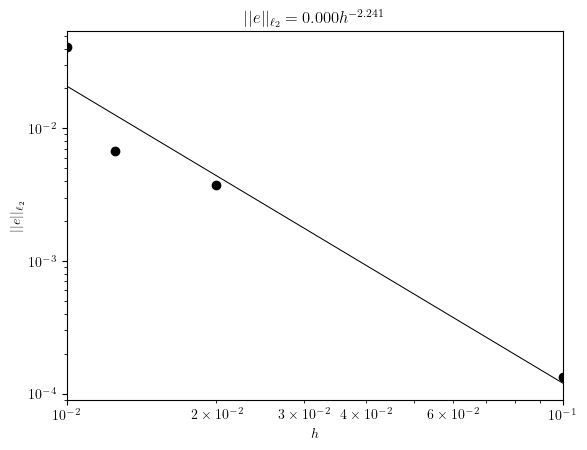

: 

In [ ]:
h_arr = np.array(list(l2_results.keys()))
l2_arr = np.array(list(l2_results.values()))
gradient, intercept = np.polyfit(np.log(h_arr), np.log(l2_arr), 1)
lobf = np.exp(intercept) * h_arr ** gradient

y_label = '||e||_{\ell_2}'
title = f'${y_label}={np.exp(intercept):.3f}h^{{{gradient:.3f}}}$'
fig, ax = plot_line(
    (h_arr, l2_arr), 
    x_label='$h$', 
    y_label=f'${y_label}$', 
    marker='o',
    linestyle='',
    title=title,
)
ax.plot(h_arr, lobf, color='black', linestyle='solid', linewidth=0.75)
ax.set_xscale('log')
ax.set_yscale('log')